In [1]:
import jax.numpy as jnp
from utils.io import load_obj, create_triangle_arrays

In [2]:
#load object

sphere_path = "objects/sphere.obj"
cube_path = "objects/cube.obj"
cylinder_path = "objects/cylinder.obj"
rabbit = "objects/rabbit.obj"
carrot = "objects/carrot.obj"
plane = "objects/plane.obj"
squirrel = "objects/squirrel.obj"
tree = "objects/broad_deciduous_tree_green_leaves.obj"
ant = "objects/ant.obj"
fireball = "objects/fireball.obj"
dragon = "objects/dragon.obj"
crawler = "objects/crawler.obj"


file_path = carrot

In [3]:
vertices, faces = load_obj(file_path)
triangle_arrays = create_triangle_arrays(vertices, faces)
triangle_arrays

{'vertex_1': Array([[-2.8973150e+00,  1.3289683e+01,  3.4134369e+00],
        [-2.3006700e-01,  1.0752763e+01,  7.9705000e-02],
        [ 1.0858000e-02,  1.0835635e+01, -2.0495400e-01],
        [ 3.9818701e-01,  1.3382749e+01,  1.9371000e-01],
        [-9.4076000e-02,  1.3273426e+01,  1.0305270e+00],
        [-1.1231000e-01,  1.4998567e+01,  5.8584201e-01],
        [-2.2138929e+00,  1.5225525e+01,  1.4856040e+00],
        [ 4.8523278e+00,  1.4013837e+01, -2.5449699e-01],
        [ 4.2591538e+00,  1.5081957e+01, -6.1435997e-01],
        [ 3.4277151e+00,  1.4238135e+01,  4.9385000e-02],
        [ 2.4769101e+00,  1.5459887e+01, -1.6992199e-01],
        [ 6.9417101e-01,  1.4996229e+01,  4.6680000e-01],
        [ 7.6956099e-01,  1.3632153e+01,  5.1836401e-01],
        [ 1.6574600e-01,  1.0752763e+01,  0.0000000e+00],
        [ 2.3400590e+00,  1.4351068e+01, -4.0018039e+00],
        [ 1.8073220e+00,  1.5251101e+01, -3.5135851e+00],
        [ 2.5343901e-01,  1.0752763e+01, -1.7044900e-01],
  

In [4]:
from accelerators.bvh_iterative import init_bvh_primitives

bvh_prims_vectorized = init_bvh_primitives(triangle_arrays)
n_primitives = triangle_arrays["vertex_1"].shape[0]
if bvh_prims_vectorized["prim_num"].shape[0] != n_primitives:
    raise ValueError("Mismatch in number of BVH primitives and primitives")

In [5]:
# This array will hold the final ordering of the primitives.
ordered_indices = jnp.arange(n_primitives)

In [6]:
# Choose a split method: e.g. 0 for SAH, 1 for middle, 2 for equal counts.
split_method = 1

In [7]:
from accelerators.bvh_iterative import build_bvh

bvh_state = build_bvh(primitives=triangle_arrays,
                      bvh_primitives=bvh_prims_vectorized,
                      ordered_indices=ordered_indices,
                      split_method=split_method)

In [8]:
from accelerators.bvh_iterative import flatten_bvh

# Flatten the BVH
linear_bvh, num_nodes = flatten_bvh(bvh_state["nodes"])

In [9]:
from accelerators.bvh import get_ordered_primitives

ordered_triangles = get_ordered_primitives(triangle_arrays, bvh_state["ordered_indices"])

In [10]:
# auto_camera.py
from math import radians, tan
from base.frame import create_frame  # from your frame.py

def compute_camera_parameters(vertices: jnp.ndarray,
                              fov: float = 45.0,
                              aspect_ratio: float = 1.0,
                              padding: float = 1.5):
    """
    Compute camera parameters from the object’s bounding box.

    Parameters:
      vertices: (N,3) array of vertex positions.
      fov: vertical field-of-view (in degrees).
      aspect_ratio: sensor (or image) aspect ratio (width / height).
      padding: multiplicative factor to add extra space around the object.

    Returns:
      camera_position: (3,) array.
      frame: a Frame object (with x, y, z basis vectors) so that the camera is
             looking at the object center.
      sensor_width: physical film width.
      sensor_height: physical film height.
    """
    # Compute the bounding box.
    bbox_min = jnp.min(vertices, axis=0)
    bbox_max = jnp.max(vertices, axis=0)
    center = (bbox_min + bbox_max) / 2.0

    # Compute a radius from the bounding box diagonal.
    diag = bbox_max - bbox_min
    radius = jnp.linalg.norm(diag) / 2.0

    # Determine the distance required so that the object fits vertically.
    # The object will fit if:
    #    sensor_height = 2 * distance * tan(fov/2)
    # and we want sensor_height >= 2 * radius (or with padding)
    distance = (radius * padding) / tan(radians(fov) / 2.0)

    # For a simple setup assume the camera looks along the positive z direction.
    # Place the camera along -z so that it looks toward the object.
    camera_position = center + jnp.array([0.0, 0.0, -distance])

    # Compute the view (look) direction (from camera to center).
    look_dir = center - camera_position
    look_dir = look_dir / jnp.linalg.norm(look_dir)

    # Define an "up" vector. (Assuming Y is up.)
    up = jnp.array([0.0, 1.0, 0.0])
    # Compute the right vector.
    right = jnp.cross(look_dir, up)
    right = right / jnp.linalg.norm(right)
    # Recompute a true up vector to ensure orthogonality.
    true_up = jnp.cross(right, look_dir)

    # Create a Frame with: x = right, y = true_up, z = look direction.
    frame = create_frame(right, true_up, look_dir)

    # Compute the sensor (film) dimensions.
    sensor_height = 2 * distance * tan(radians(fov) / 2.0)
    sensor_width = sensor_height * aspect_ratio

    return camera_position, frame, sensor_width, sensor_height


In [11]:
from base.camera import PerspectiveCamera

# Compute a proper camera setup automatically.
# For example, set the aspect ratio from your intended image size.
image_width = 100
image_height = 100
aspect_ratio = image_width / image_height
fov = 45.0  # degrees

camera_position, frame, sensor_width, sensor_height = compute_camera_parameters(
    vertices, fov=fov, aspect_ratio=aspect_ratio, padding=1.5)

# Create a PerspectiveCamera.
# For simplicity, we assume no lens (pinhole) camera, so lens_radius=0.
# We'll set dx_camera and dy_camera to small differentials.
camera = PerspectiveCamera(
    width=image_width,
    height=image_height,
    position=camera_position,
    frame=frame,
    fov=fov,
    aspect_ratio=aspect_ratio,
    lens_radius=0.0,         # pinhole camera
    focal_distance=1.0,        # not used when lens_radius==0
    screen_dx=sensor_width,    # film width
    screen_dy=sensor_height,   # film height
    dx_camera=jnp.array([0.001, 0.0, 0.0], dtype=jnp.float32),
    dy_camera=jnp.array([0.0, 0.001, 0.0], dtype=jnp.float32)
)


In [12]:
from accelerators.bvh_iterative import intersect_bvh


def render_scene_with_camera(primitives, linear_bvh, camera: PerspectiveCamera):
    import jax
    import jax.numpy as jnp
    from primitives.ray import Ray  # your ray class

    image = jnp.zeros((camera.height, camera.width, 3), dtype=jnp.float32)
    # Loop over each pixel.
    for i in range(camera.height):
        for j in range(camera.width):
            # Convert pixel (i,j) to normalized raster coordinates in [0,1].
            s = (j + 0.5) / camera.width
            t = (i + 0.5) / camera.height
            # Use the camera to generate a ray.
            world_origin, world_dir = camera.generate_ray(s, t)
            ray = Ray(world_origin, world_dir)
            # Intersect the ray with the BVH.
            hit = None
            try:
                # Your BVH intersection routine should return a hit if found.
                hit = intersect_bvh(ray, primitives, linear_bvh, 0.0, 1e10)
            except Exception as e:
                print("Intersection error:", e)
            # If a hit was found, color the pixel blue.
            if hit is not None:
                image = image.at[i, j].set(jnp.array([0.0, 0.0, 1.0], dtype=jnp.float32))
    return image

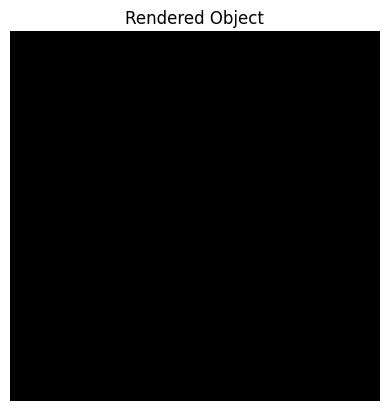

In [13]:
import numpy as np
import matplotlib.pyplot as plt

image = render_scene_with_camera(triangle_arrays, linear_bvh, camera)

# Convert to a NumPy array for visualization (e.g., with matplotlib).
plt.imshow(np.array(image))
plt.title("Rendered Object")
plt.axis("off")
plt.show()

In [10]:
from typing import Dict, Any
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from primitives.ray import spawn_ray, Ray  # your ray spawner
from primitives.aabb import AABB  # for type annotations, etc.
from accelerators.bvh_iterative import intersect_bvh  # your BVH ray-intersection routine
from utils.stdlib import push, pop

# We assume that:
# - primitives is a dictionary of geometry arrays (e.g. triangles)
# - linear_bvh is a dictionary mapping node indices to LinearBVHNode objects.
# - INF and MAX_DEPTH have been defined (see your BVH code)

# Here is a simple (non–vectorized) JAX renderer.
def render_scene(primitives: Dict[str, jnp.ndarray],
                 linear_bvh: Dict[int, Any],
                 camera_origin: jnp.ndarray = jnp.array([0.0, 0.0, 0.0], dtype=jnp.float32),
                 image_plane_z: float = 1.0,
                 image_width: int = 200,
                 image_height: int = 200,
                 fov: float = 45.0) -> jnp.ndarray:
    """
    Renders a scene by shooting rays through each pixel.

    Parameters:
      primitives: Dictionary of primitive geometry data.
      linear_bvh: Flattened BVH (mapping node indices to LinearBVHNode objects).
      camera_origin: The camera position.
      image_plane_z: The z-coordinate of the image plane.
      image_width: Image width in pixels.
      image_height: Image height in pixels.
      fov: Vertical field-of-view in degrees.

    Returns:
      A (H x W x 3) JAX array of RGB pixel colours (blue for a hit, black for no hit).
    """
    # Compute aspect ratio and scale (perspective projection)
    aspect_ratio = image_width / image_height
    scale = jnp.tan(jnp.radians(fov * 0.5))

    # Initialize the image (we use a JAX array; we can convert it to numpy later)
    image = jnp.zeros((image_height, image_width, 3), dtype=jnp.float32)

    # Loop over each pixel (for a small image this Python loop is acceptable)
    for i in range(image_height):
        for j in range(image_width):
            # Convert pixel (i, j) to normalized device coordinates.
            # x ranges from -aspect_ratio*scale (left) to +aspect_ratio*scale (right).
            # y ranges from scale (top) to -scale (bottom).
            u = (2 * (j + 0.5) / image_width - 1) * aspect_ratio * scale
            v = (1 - 2 * (i + 0.5) / image_height) * scale
            # The point on the image plane (with z = image_plane_z)
            pixel_pos = jnp.array([u, v, image_plane_z], dtype=jnp.float32)
            # Compute ray direction (from camera_origin to pixel_pos)
            ray_dir = pixel_pos - camera_origin
            ray_dir = ray_dir / jnp.linalg.norm(ray_dir)
            # Spawn a ray using your spawn_ray function.
            ray = Ray(camera_origin, ray_dir)
            # Intersect the ray with the BVH.
            hit = intersect_bvh(ray, primitives, linear_bvh, 0.0, 1e10)
            # If an intersection is found, set the pixel to blue ([0, 0, 1]).
            if hit is not None:
                image = image.at[i, j].set(jnp.array([0.0, 0.0, 1.0], dtype=jnp.float32))
            # Otherwise, it remains black ([0, 0, 0]).
    return image

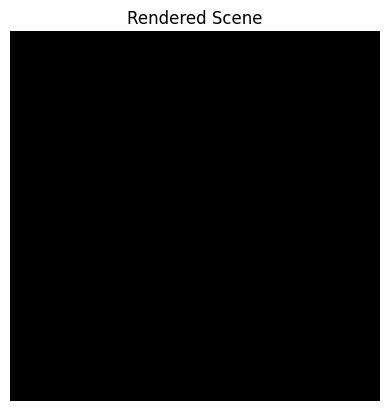

In [11]:
image_jax = render_scene(ordered_triangles, linear_bvh)
# Convert the JAX array to a NumPy array for Matplotlib.
image_np = np.array(image_jax)
plt.imshow(image_np)
plt.title("Rendered Scene")
plt.axis("off")
plt.show()

In [37]:
import jax
import jax.numpy as jnp
import numpy as np

from primitives.aabb import AABB, union, get_surface_area
from accelerators.bvh_iterative import build_bvh, flatten_bvh

# Tolerance for floating–point comparisons
RTOL = 1e-5
ATOL = 1e-5

def union_bounds(bounds1: AABB, bounds2: AABB) -> AABB:
    # Compute the union of two AABBs.
    new_min = jnp.minimum(bounds1.min_point, bounds2.min_point)
    new_max = jnp.maximum(bounds1.max_point, bounds2.max_point)
    new_centroid = (new_min + new_max) / 2.0
    return AABB(new_min, new_max, new_centroid)

def verify_linear_bvh_node(linear_bvh: dict, node_index: int) -> AABB:
    """
    Recursively verifies the invariant that for an internal node,
    the union of its children’s bounds equals (approximately)
    the node’s own bounds. Returns the union of all primitive bounds in
    the subtree rooted at this node.

    For leaf nodes, simply returns the leaf's bounds.
    """
    node = linear_bvh[node_index]
    # A leaf node is indicated by n_primitives > 0.
    if node.n_primitives > 0:
        # Return the leaf bounds.
        return node.bounds
    else:
        # For internal nodes, the left child is assumed to be at node_index + 1
        # and the right child is at node.second_child_offset.
        left_index = node_index + 1
        right_index = node.second_child_offset

        left_bounds = verify_linear_bvh_node(linear_bvh, left_index)
        right_bounds = verify_linear_bvh_node(linear_bvh, right_index)
        union_b = union_bounds(left_bounds, right_bounds)

        # Check that the parent's bounds and the union are close.
        if not (jnp.allclose(node.bounds.min_point, union_b.min_point, rtol=RTOL, atol=ATOL) and
                jnp.allclose(node.bounds.max_point, union_b.max_point, rtol=RTOL, atol=ATOL)):
            raise ValueError(f"Inconsistent BVH at node {node_index}:\n"
                             f"Parent bounds: min={node.bounds.min_point}, max={node.bounds.max_point}\n"
                             f"Union of children: min={union_b.min_point}, max={union_b.max_point}")
        return node.bounds

def count_leaf_primitives(linear_bvh: dict) -> int:
    """Recursively sum the primitives from the leaves."""
    def helper(node_index: int) -> int:
        node = linear_bvh[node_index]
        if node.n_primitives > 0:
            return node.n_primitives
        else:
            left_index = node_index + 1
            right_index = node.second_child_offset
            return helper(left_index) + helper(right_index)
    return int(helper(0))

def test_bvh(primitives: Dict[str, jnp.ndarray],
             bvh_primitives: Dict[str, jnp.ndarray],
             ordered_indices: jnp.ndarray,
             split_method: int):
    """
    Test the BVH construction by building the BVH, flattening it,
    verifying that the bounds in the linear BVH are consistent, and that
    the sum of primitives in the leaves equals the total number of primitives.
    """
    # Build the hierarchical BVH.
    state = build_bvh(primitives, bvh_primitives, ordered_indices, split_method)
    # Flatten the BVH.
    linear_bvh, total_nodes = flatten_bvh(state["nodes"])

    print(f"Total number of nodes in the linear BVH: {total_nodes}")
    print("Root node bounds:")
    print("  min_point:", linear_bvh[0].bounds.min_point)
    print("  max_point:", linear_bvh[0].bounds.max_point)

    # Recursively verify that internal nodes enclose the union of children.
    try:
        root_union = verify_linear_bvh_node(linear_bvh, 0)
        print("BVH bounds verification passed.")
    except ValueError as e:
        print("BVH bounds verification failed:")
        print(e)
        return False

    # Check that the total number of primitives (from leaves) matches.
    total_leaf_prims = count_leaf_primitives(linear_bvh)
    total_prims = int(bvh_primitives["prim_num"].shape[0])
    if total_leaf_prims != total_prims:
        print(f"Error: Total primitives in leaves ({total_leaf_prims}) != total primitives ({total_prims})")
        return False
    print(f"Total primitives in leaves: {total_leaf_prims} (matches total primitives)")
    print("BVH construction test passed.")
    return True


In [39]:
# # Here you would load or create your primitives (triangle data)
# # For example, we create a dummy test scene with random triangles.
# num_triangles = 1000
# # Create dummy triangles with random vertices.
# triangle_arrays = {
#     "vertex_1": jnp.random.uniform(0, 1, (num_triangles, 3)),
#     "vertex_2": jnp.random.uniform(0, 1, (num_triangles, 3)),
#     "vertex_3": jnp.random.uniform(0, 1, (num_triangles, 3))
# }
# # Initialize BVH primitives.
# bvh_prims = init_bvh_primitives(triangle_arrays)
# # Create an ordered_indices array.
# ordered_indices = jnp.arange(num_triangles, dtype=jnp.int32)
# # Choose a split method (for now, assume an integer flag, e.g., 0).
# split_method = 0

# Run the test.
test_bvh(triangle_arrays, bvh_prims, ordered_indices, split_method)

Total number of nodes in the linear BVH: 2
Root node bounds:
  min_point: [-4.933327  0.016136 -4.001804]
  max_point: [ 4.852329 16.596111  3.413437]


KeyError: -1